In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm as tqdm
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from IPython.display import clear_output

path_to_data = '../Inputs-Targets.csv'

In [2]:
class WeatherDataset(Dataset):
    def __init__(self, csv_file, seq_length=8, train=True):
        
        self.data = pd.read_csv(csv_file)
        self.seq_length = seq_length
        self.train = train
        # Get rid of the first column
        self.data = self.data.iloc[:,1:]
        self.data = torch.tensor(self.data.values).to(torch.float64)

        # Divide the data into windows of size seq_length
        self.data = self.data.view(-1, seq_length, 71)

        # randomly (with consistant seed) shuffle windows along axis 0
        torch.manual_seed(0)
        perm = torch.randperm(self.data.size(0))
        self.data = self.data[perm]
        self.data = self.data[torch.randperm(self.data.size()[0])]

        if train:
            self.data = self.data[:int(len(self.data)*0.8)]
        else:
            self.data = self.data[int(len(self.data)*0.8):]

    def __len__(self):
        return (len(self.data)-self.seq_length)

    def __getitem__(self, i):
        # x is a tensor of shape (seq_length, 68)
        # y is a tensor of shape (3,)
        x = self.data[i,:,:-3].reshape(-1)
        y = self.data[i,-1,-3:]
        return x, y

In [3]:
# original_tensor = torch.arange(64 * 7).reshape(64, 7)

# print(original_tensor)

# # Reshape the tensor
# x_sand = original_tensor.view(16, 4, 7)

# torch.manual_seed(0)
# perm = torch.randperm(x_sand.size(0))
# x_sand = x_sand[perm]
# # x_sand = x_sand[torch.randperm(x_sand.size()[0])]

# # Print the slice tensor
# print(x_sand[0, :, :])
# print(x_sand[1, :, :])

In [4]:
# t_data = WeatherDataset(path_to_data)
# v_data = WeatherDataset(path_to_data, train=False)

In [5]:
# Test dataset class

# t_data = WeatherDataset(path_to_data)
# t_dataloader = DataLoader(t_data, batch_size=4, shuffle=True)
# print(len(t_dataloader.dataset))
# for batch in t_dataloader:
#     x, y = batch
#     print(x.shape)
#     print(y.shape)
#     break

# v_data = WeatherDataset(path_to_data, train=False)
# v_dataloader = DataLoader(v_data, batch_size=4, shuffle=True)
# print(len(v_dataloader.dataset))
# for batch in v_dataloader:
#     x, y = batch
#     print(x.shape)
#     print(y.shape)
#     break

In [14]:
resnet = models.resnet50(pretrained=True)

# Define trivial model
class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(544, 256, dtype=torch.float64)
        self.fc2 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc3 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc4 = nn.Linear(512, 256, dtype=torch.float64)
        self.fcf = nn.Linear(256, 3, dtype=torch.float64)

        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fcf]:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x_prime = torch.relu(self.fc2(x))
        x = torch.relu(torch.cat([self.fc3(x_prime), x_prime], dim=-1))
        x = torch.relu(self.fc4(x))
        return self.fcf(x)

# Define resnet model
class Res50Model(nn.Module):
    def __init__(self):
        super(Res50Model, self).__init__()
        self.input_layer = nn.Linear(68, 224 * 224 * 3, dtype=torch.float64)
        self.resnet = resnet.double()
        self.output_layer = nn.Linear(1000, 3, dtype=torch.float64)

    def forward(self, x):
        x = self.input_layer(x)
        x = x.view(-1, 3, 224, 224)
        x = self.resnet(x)
        x = self.output_layer(x)
        return x

In [10]:
BATCH_SIZE = 4
UPDATE_STATUS_EVERY = 200

# Make train and test datasets
train_data = WeatherDataset(path_to_data, train=True)
test_data = WeatherDataset(path_to_data, train=False)
# Initialize dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [24]:
def cache_session(model, path='model.pt', stat_dict={}):
    torch.save(model.state_dict(), path)
    torch.save(stat_dict, 'stat_dict.pt')


def restore_session(model, model_path='model.pt', stat_dict_path='stat_dict.pt'):
   # Restore model and stats from cache if available, else initialize new model and stats
    try:
        model.load_state_dict(torch.load(model_path))
        stat_dict = torch.load(stat_dict_path)
        losses = stat_dict['losses']
        window_losses = stat_dict['window_losses']
        val_losses = stat_dict['val_losses']
        epoch_num = stat_dict['epoch_num']
        print('Restored session from cache at epoch {}'.format(epoch_num))
    except:
        losses = []
        window_losses = []
        val_losses = []
        epoch_num = 0
        print('Unable to restore. Initialized new model and new session')
    return model, epoch_num, losses, window_losses, val_losses

def plot_loss(losses, loss_indices, start_index=0, end_index=-1):
  if start_index > len(loss_indices[0]):
     print("Plot will display in a few more cycles")
     return
  for i, l in enumerate(losses):
    loss_label = l[0]
    loss_x = loss_indices[i][start_index:end_index]
    loss_y = l[1][start_index:end_index]
    plt.plot(loss_x, loss_y, label=loss_label)
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('Batches')
  plt.show()

 35%|###5      | 105/300 [00:00<?, ?it/s]

  0%|          | 0/1362 [00:00<?, ?it/s]

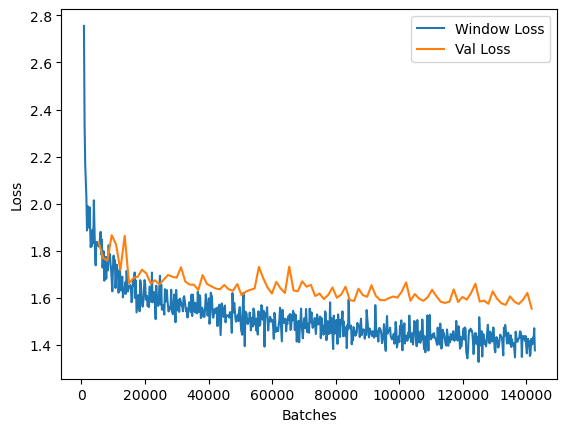

KeyboardInterrupt: 

In [28]:
# Train model
def train(epochs, model, epoch_num=0, losses_tuple=([], []), window_losses_tuple=([], []), val_losses_tuple=([], [])):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    if window_losses_tuple[0] == []:
      total_batch_index = 0
    else:
      total_batch_index = window_losses_tuple[0][-1] + 1
    
    loss_indices = losses_tuple[0]
    losses = losses_tuple[1]
    window_loss_indices = window_losses_tuple[0]
    window_losses = window_losses_tuple[1]
    val_loss_indices = val_losses_tuple[0]
    val_losses = val_losses_tuple[1]

    # epochs_bar = tqdm(range(epochs), leave=False, position=epoch_num)

    for epoch in range(epoch_num, epochs):
        
        # Reset output for current epoch
        clear_output(wait=True)
        epochs_bar = tqdm(range(epochs), leave=False, initial=epoch) # Reset epochs bar
        try:
            epochs_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}, Val Loss: {f"{avg_val_batch_loss:.3f}"}')
        except:
            epochs_bar.set_description(f'Epoch {epoch_num + 1}, Train Loss: N/A, Val Loss: N/A')

        batches_bar = tqdm(train_dataloader, leave=False)
        plot_loss(losses=(('Window Loss', window_losses), ('Val Loss', val_losses)),
                   loss_indices=(window_loss_indices, val_loss_indices), start_index=3) # Plot current losses

        for batch in train_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_indices.append(total_batch_index)
            losses.append(loss.item())
            batches_bar.update()
            total_batch_index += 1

            # Update batch bar periodically during batch
            if batches_bar.n % UPDATE_STATUS_EVERY == 0:
                recent_avg_loss = sum(losses[-UPDATE_STATUS_EVERY:])/UPDATE_STATUS_EVERY
                window_loss_indices.append(total_batch_index)
                window_losses.append(recent_avg_loss)
                batches_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}')

        # Validate every epoch
        val_batches_bar = tqdm(test_dataloader, leave=False)
        val_batches_bar.set_description(f'Validating...')
        val_batches_bar.update()
        val_batch_losses = []
        model.eval()
        for batch in test_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_batch_losses.append(loss.item())
            val_batches_bar.update()
        avg_val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
        val_loss_indices.append(total_batch_index)
        val_losses.append(avg_val_batch_loss)
        model.train()

        # Save model and losses
        stat_dict = {'epoch_num': epoch + 1,'losses': (loss_indices, losses), 'window_losses': (window_loss_indices, window_losses), 'val_losses': (val_loss_indices, val_losses)}
        cache_session(model ,stat_dict=stat_dict)

        # Update epoch bar
        epochs_bar.update()

model = WeatherModel()
# model = Res50Model()
EPOCHS = 300
do_restore = True
if do_restore:
    train(EPOCHS, *restore_session(model))
else:
    print('Initialized new model and new session')
    train(EPOCHS, model)

In [34]:
def validate_model(model, epoch_num=0, losses_tuple=([], []), window_losses_tuple=([], []), val_losses_tuple=([], [])):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.MSELoss()
    val_batches_bar = tqdm(test_dataloader, leave=False)
    val_batches_bar.set_description(f'Validating...')
    val_batches_bar.update()
    val_batch_losses = []
    corrects = 0
    val_loader_data_count = len(test_dataloader.dataset)*test_dataloader.batch_size*3
    model.eval()
    for batch in test_dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)

        # Calculate loss
        loss = criterion(y_pred, y)

        # Calculate accuracy
        descrete_pred = torch.round(y_pred).clamp(1, 5)
        correct = torch.sum(descrete_pred == y)
        corrects += correct.item()

        val_batch_losses.append(loss.item())
        val_batches_bar.update()
    val_batches_bar.update()
    avg_val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    avg_accuracy = corrects/val_loader_data_count
    model.train()

    loss_indices = losses_tuple[0]
    losses = losses_tuple[1]
    window_loss_indices = window_losses_tuple[0]
    window_losses = window_losses_tuple[1]
    val_loss_indices = val_losses_tuple[0]
    val_losses = val_losses_tuple[1]
    plot_loss(losses=(('Window Loss', window_losses), ('Val Loss', val_losses)),
                   loss_indices=(window_loss_indices, val_loss_indices), start_index=3)
    
    print(f'Val Loss: {f"{avg_val_batch_loss:.4}"}')
    print(f'Accuracy: {f"{avg_accuracy:.4}"}')

Restored session from cache at epoch 105


  0%|          | 0/339 [00:00<?, ?it/s]

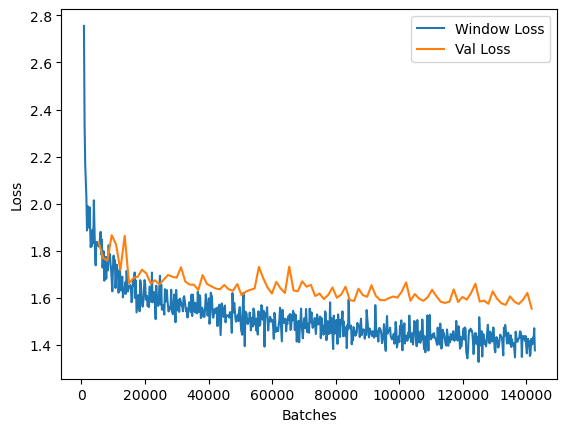

Val Loss: 1.549
Accuracy: 0.06613


In [35]:
model = WeatherModel()
validate_model(*restore_session(model))